In [1]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        l = str(json.loads(l))
        yield eval(l)

In [3]:
data_modcloth = []
for l in parse("modcloth_final_data.json.gz"):
    
    data_modcloth.append(l)

In [190]:
data_renttherunway = []
for l in parse("renttherunway_final_data.json.gz"):
    
    data_renttherunway.append(l)

In [191]:
data_renttherunway[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [192]:
len(data_renttherunway)

192544

Clean/EDA Heights

In [127]:
def standardize_height(str_in):

    str_in = str_in.strip()
    if '\'' in str_in:
        str_in = str_in.replace('\'', '')
    if '"' in str_in:
        str_in = str_in.replace('"', '')

    foot,inch = str_in.strip().split(' ')
    output = int(foot) * 12 + int(inch)

    return output

In [206]:
original_heights = [d['height'] for d in data_renttherunway if d.get('height') != None]
heights = [standardize_height(h) for h in original_heights]

In [207]:
len(heights), np.mean(heights), np.median(heights)

(191867, 65.31062142004617, 65.0)

In [208]:
np.unique(heights)

array([54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 78])

Text(0.5, 0, 'height (inch)')

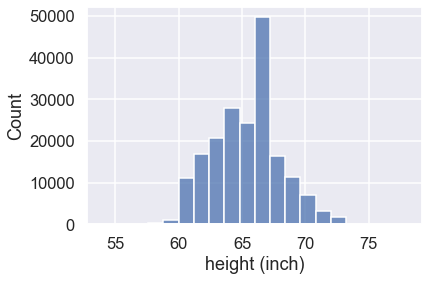

In [205]:
sns.histplot(data=heights, bins=20)
plt.xlabel('height (inch)')

In [179]:
heights = []
for d in data_renttherunway:

    if d.get('height') != None:
        d['height'] = standardize_height(d['height'])
        heights.append(d['height'])
    else:
        data_renttherunway.remove(d)


In [180]:
len(data_renttherunway)

191869

In [181]:
[d.get('height') for d in data_renttherunway][-90]

'5\' 2"'

In [132]:
data_renttherunway[-90]

{'fit': 'fit',
 'user_id': '579302',
 'bust size': '34c',
 'item_id': '131533',
 'weight': '121lbs',
 'rating': '10',
 'rented for': 'wedding',
 'review_text': 'I got a lot of compliments for this dress at the wedding and also on social media. I really felt elegant and pretty. I wore it to a fall wedding.',
 'body type': 'petite',
 'review_summary': 'It was a little long, but with tall shoes it worked. ',
 'category': 'gown',
 'height': '5\' 2"',
 'size': 8,
 'age': '36',
 'review_date': 'December 2, 2014'}

In [187]:
c=0
for d in data_renttherunway:
    a = d.get('height')
#     if a == None:
    if type(a) == str:
#         print(d)
        c+=1
    
c

673

In [227]:
# [d.get('height') for d in data_renttherunway]

Clean/EDA Weights

In [210]:
len([d.get('weight') for d in data_renttherunway])

192544

In [141]:
def standardize_weight(str_in):

    if 'lbs' in str_in:
        str_in = str_in.replace('lbs', '')
    if(str_in.isnumeric()):
        return int(str_in)

    return str_in

In [216]:
original_weights = [d['weight'] for d in data_renttherunway if d.get('weight') != None]
weights = [standardize_weight(h) for h in original_weights]

In [217]:
len(weights), np.mean(weights), np.median(weights)

(162562, 137.39170900948562, 135.0)

In [220]:
len(np.unique(weights))

190

Text(0.5, 0, 'weight (lbs)')

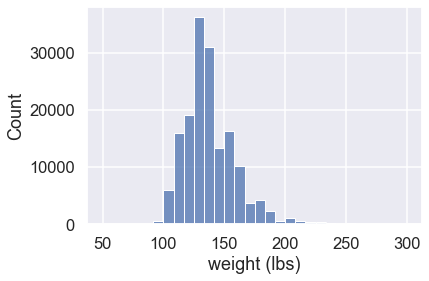

In [221]:
sns.histplot(data=weights, bins=30)
plt.xlabel('weight (lbs)')

In [222]:
weights = []
for d in data_renttherunway:

    if d.get('weight') != None:
        d['weight'] = standardize_weight(d['weight'])
        weights.append(d['weight'])
    else:
        data_renttherunway.remove(d)

In [223]:
len(data_renttherunway)

166591

In [225]:
# [d.get('weight') for d in data_renttherunway]